In [1]:
%load_ext autoreload

In [3]:
%autoreload 2

from delase import DeLASE
from delase.dmd import embed_signal_torch
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.signal as signal
from sklearn.decomposition import PCA
import socket
import sys

from UniversalUnconsciousness.data_utils import filter_data
from UniversalUnconsciousness.hdf5_utils import TransposedDatasetView

In [5]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [321]:
# session = "SPOCK_Ketamine_20210727"
# session = 'SPOCK_Dexmedetomidine_20210923'

cfg.params.data_class = 'propofolPuffTone'
session = 'Mary-Anesthesia-20160822-02'

In [322]:
if 'propofol' in cfg.params.data_class:
    session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class, f"{session}.mat"))
else:
    session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"))

In [323]:
noise_filter_info = {}

noise_filter_dir = os.path.join(cfg.params.noise_filter_results_dir, cfg.params.data_class)
os.makedirs(noise_filter_dir, exist_ok=True)
noise_filter_file = f"{session}__window_{cfg.params.window}__wakethresh_{cfg.params.wake_amplitude_thresh}__anesthesiathresh_{cfg.params.anesthesia_amplitude_thresh}__electrodenum_{cfg.params.electrode_num_thresh}.pkl"

print("--------------------")
print(f"Session: {session}")
print("--------------------")
if noise_filter_file in os.listdir(noise_filter_dir):
    noise_filter_info[session] = pd.read_pickle(os.path.join(noise_filter_dir, noise_filter_file))
else:
    print("Finding noisy data...")
    window_df, bad_electrodes, valid_window_starts = find_noisy_data(cfg, session)
    noise_filter_info[session] = dict(
        window_df=window_df,
        bad_electrodes=bad_electrodes,
        valid_window_starts=valid_window_starts
    )
    pd.to_pickle(noise_filter_info[session], os.path.join(noise_filter_dir, noise_filter_file))

--------------------
Session: Mary-Anesthesia-20160822-02
--------------------


In [326]:
if 'propofol' in cfg.params.data_class:
    infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
else:
    infusion_start = session_file['sessionInfo']['infusionStart'][0, 0]
dt = session_file['lfpSchema']['smpInterval'][0, 0]

In [327]:
lfp = TransposedDatasetView(session_file['lfp']).transpose()

In [328]:
bad_electrodes = noise_filter_info[session]['bad_electrodes']
valid_window_starts = noise_filter_info[session]['valid_window_starts']

In [329]:
valid_electrodes = np.setdiff1d(np.arange(lfp.shape[1]), bad_electrodes)

In [330]:
wake_start = infusion_start - 15*60
wake_start =valid_window_starts[np.abs(wake_start - valid_window_starts).argmin()]
unconscious_start = infusion_start + 14*60
unconscious_start = valid_window_starts[np.abs(unconscious_start - valid_window_starts).argmin()]

In [331]:
lfp_wake = lfp[int(wake_start/dt):int((wake_start + cfg.params.window)/dt), valid_electrodes]
lfp_unconscious = lfp[int(unconscious_start/dt):int((unconscious_start + cfg.params.window)/dt), valid_electrodes]

high_pass = 30
low_pass = 80
order = 4
bidirectional = False
lfp_wake_filt = filter_data(lfp_wake, low_pass, high_pass, order=order, bidirectional=bidirectional)
lfp_unconscious_filt = filter_data(lfp_unconscious, low_pass, high_pass, order=order, bidirectional=bidirectional)

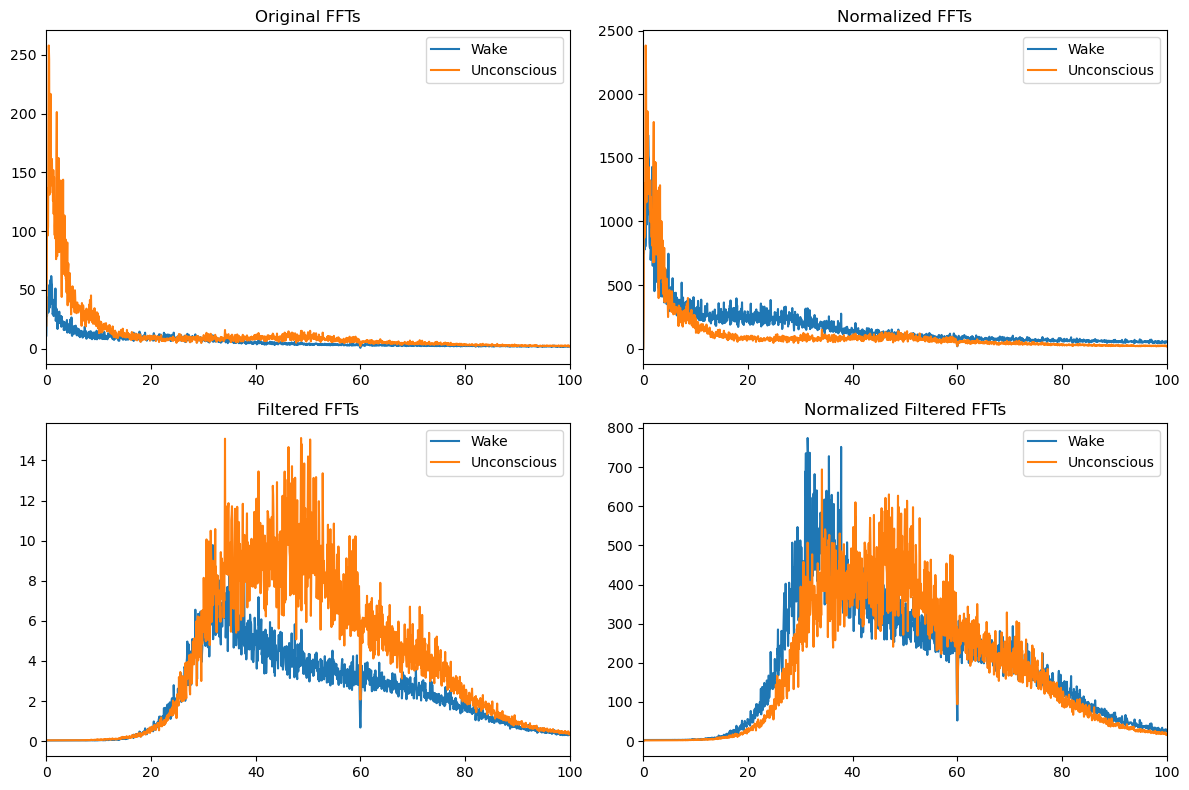

In [197]:
lfp_wake_fft = np.fft.rfft(lfp_wake, axis=0)
lfp_unconscious_fft = np.fft.rfft(lfp_unconscious, axis=0)
lfp_wake_filt_fft = np.fft.rfft(lfp_wake_filt, axis=0)
lfp_unconscious_filt_fft = np.fft.rfft(lfp_unconscious_filt, axis=0)

freqs = np.fft.rfftfreq(lfp_wake.shape[0], d=dt)

# Normalize FFTs
lfp_wake_norm = (lfp_wake - lfp_wake.mean(axis=0)) / lfp_wake.std(axis=0)
lfp_unconscious_norm = (lfp_unconscious - lfp_unconscious.mean(axis=0)) / lfp_unconscious.std(axis=0)
lfp_wake_filt_norm = (lfp_wake_filt - lfp_wake_filt.mean(axis=0)) / lfp_wake_filt.std(axis=0)
lfp_unconscious_filt_norm = (lfp_unconscious_filt - lfp_unconscious_filt.mean(axis=0)) / lfp_unconscious_filt.std(axis=0)
lfp_wake_fft_norm = np.fft.rfft(lfp_wake_norm, axis=0)
lfp_unconscious_fft_norm = np.fft.rfft(lfp_unconscious_norm, axis=0)
lfp_wake_filt_fft_norm = np.fft.rfft(lfp_wake_filt_norm, axis=0)
lfp_unconscious_filt_fft_norm = np.fft.rfft(lfp_unconscious_filt_norm, axis=0)
# lfp_wake_fft_norm = lfp_wake_fft / np.abs(lfp_wake_fft).max(axis=0)
# lfp_unconscious_fft_norm = lfp_unconscious_fft / np.abs(lfp_unconscious_fft).max(axis=0)
# lfp_wake_filt_fft_norm = lfp_wake_filt_fft / np.abs(lfp_wake_filt_fft).max(axis=0)
# lfp_unconscious_filt_fft_norm = lfp_unconscious_filt_fft / np.abs(lfp_unconscious_filt_fft).max(axis=0)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot original FFTs
axs[0, 0].plot(freqs, np.abs(lfp_wake_fft).mean(axis=1), label='Wake')
axs[0, 0].plot(freqs, np.abs(lfp_unconscious_fft).mean(axis=1), label='Unconscious')
axs[0, 0].set_xlim(0, 100)
axs[0, 0].set_title('Original FFTs')
axs[0, 0].legend()

# Plot normalized FFTs
axs[0, 1].plot(freqs, np.abs(lfp_wake_fft_norm).mean(axis=1), label='Wake')
axs[0, 1].plot(freqs, np.abs(lfp_unconscious_fft_norm).mean(axis=1), label='Unconscious')
axs[0, 1].set_xlim(0, 100)
axs[0, 1].set_title('Normalized FFTs')
axs[0, 1].legend()

# Plot filtered FFTs
axs[1, 0].plot(freqs, np.abs(lfp_wake_filt_fft).mean(axis=1), label='Wake')
axs[1, 0].plot(freqs, np.abs(lfp_unconscious_filt_fft).mean(axis=1), label='Unconscious')
axs[1, 0].set_xlim(0, 100)
axs[1, 0].set_title('Filtered FFTs')
axs[1, 0].legend()

# Plot normalized filtered FFTs
axs[1, 1].plot(freqs, np.abs(lfp_wake_filt_fft_norm).mean(axis=1), label='Wake')
axs[1, 1].plot(freqs, np.abs(lfp_unconscious_filt_fft_norm).mean(axis=1), label='Unconscious')
axs[1, 1].set_xlim(0, 100)
axs[1, 1].set_title('Normalized Filtered FFTs')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [198]:

n_delays = 8 
rank = 900
delase_wake = DeLASE(lfp_wake, n_delays=n_delays, rank=rank, dt=dt, device='cuda')
delase_wake.fit()
delase_unconscious = DeLASE(lfp_unconscious, n_delays=n_delays, rank=rank, dt=dt, device='cuda')
delase_unconscious.fit()
delase_wake_filt = DeLASE(lfp_wake_filt_norm, n_delays=n_delays, rank=rank, dt=dt, device='cuda')
delase_wake_filt.fit()
delase_unconscious_filt = DeLASE(lfp_unconscious_filt_norm, n_delays=n_delays, rank=rank, dt=dt, device='cuda')
delase_unconscious_filt.fit()


In [199]:
top_percent = 0.1

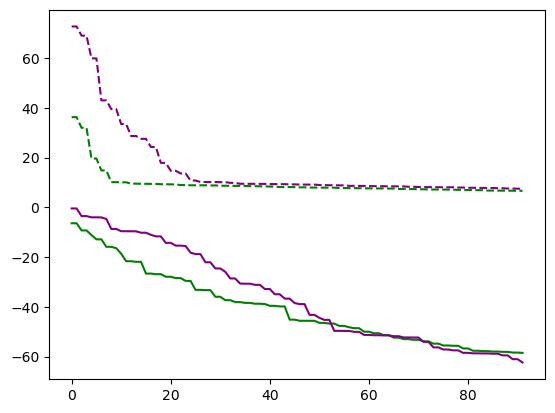

In [200]:
plt.plot(delase_wake.stability_params[:int(top_percent*len(delase_wake.stability_params))].cpu().numpy(), c='green')
plt.plot(delase_unconscious.stability_params[:int(top_percent*len(delase_unconscious.stability_params))].cpu().numpy(), c='purple')
plt.plot(delase_wake_filt.stability_params[:int(top_percent*len(delase_wake_filt.stability_params))].cpu().numpy(), c='green', ls='--')
plt.plot(delase_unconscious_filt.stability_params[:int(top_percent*len(delase_unconscious_filt.stability_params))].cpu().numpy(), c='purple', ls='--')
plt.show()


In [183]:
delase_wake.stability_params[:int(top_percent*len(delase_wake.stability_params))].cpu().numpy().mean() - delase_unconscious.stability_params[:int(top_percent*len(delase_unconscious.stability_params))].cpu().numpy().mean()

np.float32(-4.725872)

In [184]:
delase_wake_filt.stability_params[:int(top_percent*len(delase_wake_filt.stability_params))].cpu().numpy().mean() - delase_unconscious_filt.stability_params[:int(top_percent*len(delase_unconscious_filt.stability_params))].cpu().numpy().mean()

np.float32(-0.31307602)

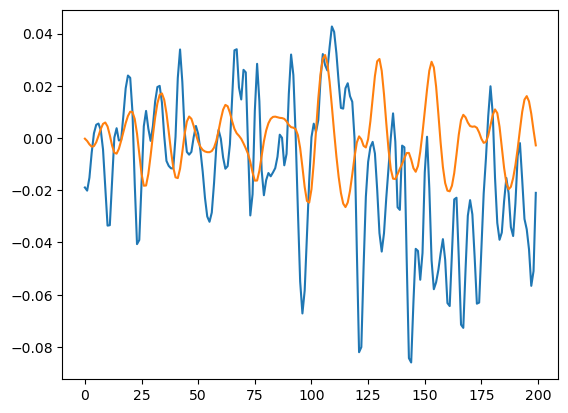

In [185]:
plt.plot(lfp_wake[:200, 0])
plt.plot(lfp_wake_filt[:200, 0])

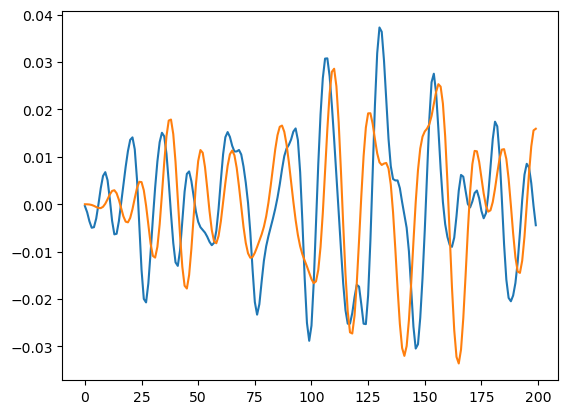

In [41]:
lfp_wake_filtv1 = filter_data(lfp_wake, low_pass, high_pass, order=2)
lfp_wake_filtv2 = filter_data(lfp_wake, low_pass, high_pass, order=5)
plt.plot(lfp_wake_filtv1[:200, 0])
plt.plot(lfp_wake_filtv2[:200, 0])
plt.show()

# LFP Testing

In [365]:
order = 2

# low_pass = 0.1
# high_pass = 4

low_pass = 300
high_pass = None

# high_pass = 0.1
# low_pass = 4

# high_pass = 30
# low_pass = 80

lfp_wake_filt_v1 = filter_data(lfp_wake, low_pass, high_pass, order=order, bidirectional=True)
lfp_unconscious_filt_v1 = filter_data(lfp_unconscious, low_pass, high_pass, order=order, bidirectional=True)
lfp_wake_filt_v2 = filter_data(lfp_wake, low_pass, high_pass, order=2*order, bidirectional=False)
lfp_unconscious_filt_v2 = filter_data(lfp_unconscious, low_pass, high_pass, order=2*order, bidirectional=False)

noise_vals = np.random.randn(lfp_wake.shape[0], lfp_wake.shape[1])*lfp_wake.std()*0

delase_wake_filt_v1 = DeLASE(lfp_wake_filt_v1 + noise_vals, n_delays=n_delays, rank=rank, dt=dt, device='cuda')
delase_wake_filt_v1.fit()
delase_unconscious_filt_v1 = DeLASE(lfp_unconscious_filt_v1 + noise_vals, n_delays=n_delays, rank=rank, dt=dt, device='cuda')
delase_unconscious_filt_v1.fit()
delase_wake_filt_v2 = DeLASE(lfp_wake_filt_v2 + noise_vals, n_delays=n_delays, rank=rank, dt=dt, device='cuda')
delase_wake_filt_v2.fit()
delase_unconscious_filt_v2 = DeLASE(lfp_unconscious_filt_v2 + noise_vals, n_delays=n_delays, rank=rank, dt=dt, device='cuda')
delase_unconscious_filt_v2.fit()


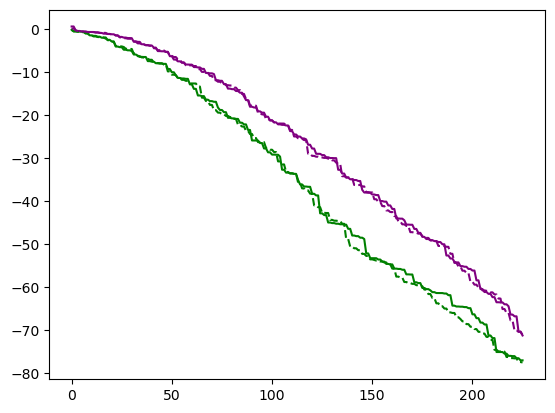

In [369]:

top_percent = 0.1
plt.plot(delase_wake_filt_v1.stability_params[:int(top_percent*len(delase_wake_filt_v1.stability_params))].cpu().numpy(), c='green')
plt.plot(delase_unconscious_filt_v1.stability_params[:int(top_percent*len(delase_unconscious_filt_v1.stability_params))].cpu().numpy(), c='purple')
plt.plot(delase_wake_filt_v2.stability_params[:int(top_percent*len(delase_wake_filt_v2.stability_params))].cpu().numpy(), c='green', ls='--')
plt.plot(delase_unconscious_filt_v2.stability_params[:int(top_percent*len(delase_unconscious_filt_v2.stability_params))].cpu().numpy(), c='purple', ls='--')
plt.show()

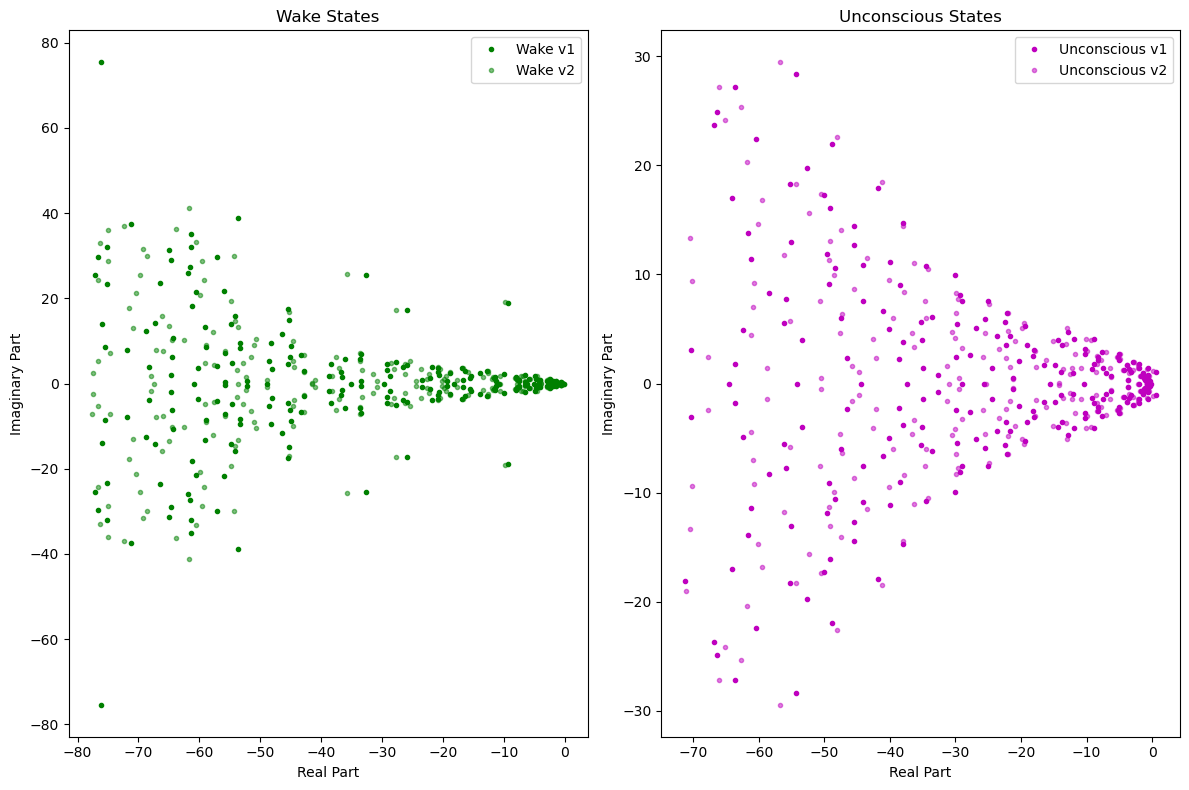

In [373]:
plt.figure(figsize=(12,8))

top_percent = 0.1

plt.subplot(121)
plt.plot(delase_wake_filt_v1.stability_params[:int(top_percent*len(delase_wake_filt_v1.stability_params))].cpu().numpy(), 
         delase_wake_filt_v1.stability_freqs[:int(top_percent*len(delase_wake_filt_v1.stability_freqs))].cpu().numpy(), 
         'g.', label='Wake v1')
plt.plot(delase_wake_filt_v2.stability_params[:int(top_percent*len(delase_wake_filt_v2.stability_params))].cpu().numpy(),
         delase_wake_filt_v2.stability_freqs[:int(top_percent*len(delase_wake_filt_v2.stability_freqs))].cpu().numpy(),
         'g.', alpha=0.5, label='Wake v2')
plt.legend()
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Wake States')

plt.subplot(122)
plt.plot(delase_unconscious_filt_v1.stability_params[:int(top_percent*len(delase_unconscious_filt_v1.stability_params))].cpu().numpy(),
         delase_unconscious_filt_v1.stability_freqs[:int(top_percent*len(delase_unconscious_filt_v1.stability_freqs))].cpu().numpy(),
         'm.', label='Unconscious v1')
plt.plot(delase_unconscious_filt_v2.stability_params[:int(top_percent*len(delase_unconscious_filt_v2.stability_params))].cpu().numpy(),
         delase_unconscious_filt_v2.stability_freqs[:int(top_percent*len(delase_unconscious_filt_v2.stability_freqs))].cpu().numpy(),
         'm.', alpha=0.5, label='Unconscious v2')
plt.legend()
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Unconscious States')

plt.tight_layout()
plt.show()


In [367]:
diff1 = delase_wake_filt_v1.stability_params[:int(top_percent*len(delase_wake_filt_v1.stability_params))].cpu().numpy().mean() - delase_unconscious_filt_v1.stability_params[:int(top_percent*len(delase_unconscious_filt_v1.stability_params))].cpu().numpy().mean()
diff2 = delase_wake_filt_v2.stability_params[:int(top_percent*len(delase_wake_filt_v2.stability_params))].cpu().numpy().mean() - delase_unconscious_filt_v2.stability_params[:int(top_percent*len(delase_unconscious_filt_v2.stability_params))].cpu().numpy().mean()
diff1, diff2

(np.float32(-8.03072), np.float32(-8.449905))

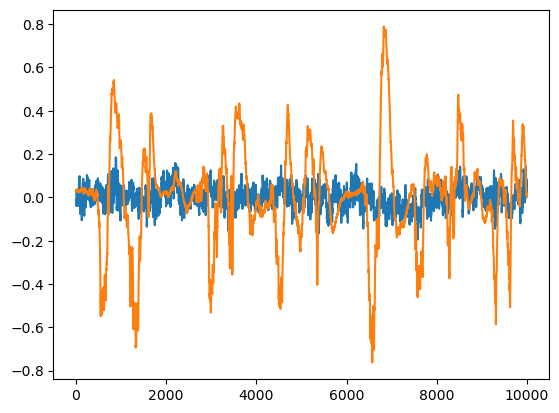

In [354]:
plt.plot(lfp_wake[:10000, 0])
plt.plot(lfp_unconscious[:10000, 0])
plt.show()

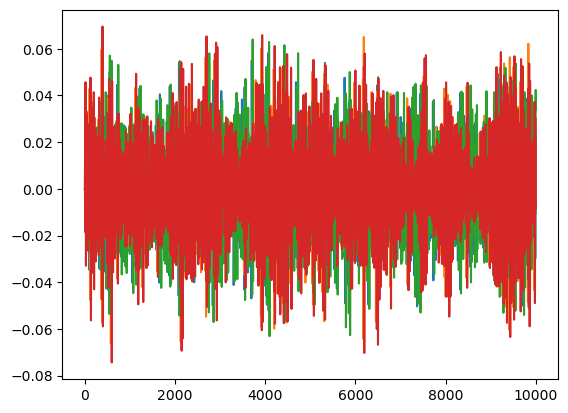

In [299]:
plt.plot(lfp_wake_filt_v1[:10000, 0])
plt.plot(lfp_unconscious_filt_v1[:10000, 0])
plt.plot(lfp_wake_filt_v2[:10000, 0])
plt.plot(lfp_unconscious_filt_v2[:10000, 0])
plt.show()
